In [ ]:
# This file runs the Detectron2 Faster R-CNN model on a custom dataset 
# This is based on the Detectron2 beginner tutorial from here:
# https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=ZyAvNCJMmvFF

# Also,checkout here: https://detectron2.readthedocs.io/en/latest/tutorials/models.html#model-output-format%20for%20specification

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
print(torchvision.__version__)
!gcc --version

1.7.1 True
0.8.2
gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
from platform import python_version
print(python_version())

3.8.5


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

print("done")

done


In [5]:
import cv2
print(cv2.__version__)

4.5.1


In [6]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.data.datasets import register_coco_instances
register_coco_instances("DoorDetectVer1_train", {}, "/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train.json", "/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train")
register_coco_instances("DoorDetectVer1_test", {}, "/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test.json", "/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test")
DoorDetectVer1_metadata = MetadataCatalog.get("DoorDetectVer1_train")

In [7]:
print(DoorDetectVer1_metadata)

Metadata(evaluator_type='coco', image_root='/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train', json_file='/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train.json', name='DoorDetectVer1_train')


In [8]:
dataset_dicts_train = DatasetCatalog.get("DoorDetectVer1_train")
print(DoorDetectVer1_metadata)

[03/12 15:56:32 d2.data.datasets.coco]: Loaded 972 images in COCO format from /home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train.json
Metadata(evaluator_type='coco', image_root='/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train', json_file='/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train.json', name='DoorDetectVer1_train', thing_classes=['door', 'handle', 'cabinet door', 'refrigerator door'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3})


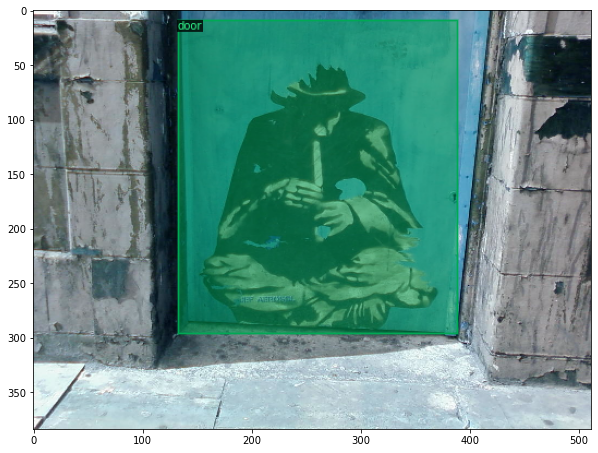

In [16]:
for d in random.sample(dataset_dicts_train, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=DoorDetectVer1_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    #cv2_imshow(vis.get_image()[:,:,::-1])
    plt.figure(figsize=(10,10))
    imgplot = plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
    

## Faster R-CNN

In [83]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("DoorDetectVer1_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/12 17:27:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[03/12 17:27:31 d2.data.datasets.coco]: Loaded 972 images in COCO format from /home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train.json
[03/12 17:27:31 d2.data.build]: Removed 0 images with no usable annotations. 972 images left.
[03/12 17:27:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/12 17:27:31 d2.data.build]: Using training sampler TrainingSampler
[03/12 17:27:31 d2.data.common]: Serializing 972 elements to byte tensors and concatenating them all ...
[03/12 17:27:31 d2.data.common]: Serialized dataset takes 1.06 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.


[03/12 17:27:31 d2.engine.train_loop]: Starting training from iteration 0
[03/12 17:27:35 d2.utils.events]:  eta: 0:33:55  iter: 19  total_loss: 3.127  loss_cls: 1.608  loss_box_reg: 0.3699  loss_rpn_cls: 0.9348  loss_rpn_loc: 0.1239  time: 0.2268  data_time: 0.0265  lr: 4.9953e-06  max_mem: 3322M
[03/12 17:27:40 d2.utils.events]:  eta: 0:33:21  iter: 39  total_loss: 2.674  loss_cls: 1.527  loss_box_reg: 0.3361  loss_rpn_cls: 0.621  loss_rpn_loc: 0.08231  time: 0.2231  data_time: 0.0132  lr: 9.9902e-06  max_mem: 3322M
[03/12 17:27:44 d2.utils.events]:  eta: 0:33:17  iter: 59  total_loss: 2.86  loss_cls: 1.367  loss_box_reg: 0.4262  loss_rpn_cls: 0.9478  loss_rpn_loc: 0.1812  time: 0.2163  data_time: 0.0040  lr: 1.4985e-05  max_mem: 3322M
[03/12 17:27:48 d2.utils.events]:  eta: 0:33:41  iter: 79  total_loss: 2.078  loss_cls: 1.187  loss_box_reg: 0.4857  loss_rpn_cls: 0.2273  loss_rpn_loc: 0.06364  time: 0.2167  data_time: 0.0026  lr: 1.998e-05  max_mem: 3322M
[03/12 17:27:52 d2.utils.ev

[03/12 17:30:05 d2.utils.events]:  eta: 0:31:41  iter: 719  total_loss: 1.137  loss_cls: 0.4232  loss_box_reg: 0.5928  loss_rpn_cls: 0.05814  loss_rpn_loc: 0.109  time: 0.2137  data_time: 0.0045  lr: 0.00017982  max_mem: 3322M
[03/12 17:30:09 d2.utils.events]:  eta: 0:31:39  iter: 739  total_loss: 1.085  loss_cls: 0.3844  loss_box_reg: 0.5522  loss_rpn_cls: 0.05715  loss_rpn_loc: 0.0683  time: 0.2140  data_time: 0.0026  lr: 0.00018482  max_mem: 3322M
[03/12 17:30:14 d2.utils.events]:  eta: 0:31:33  iter: 759  total_loss: 1.373  loss_cls: 0.4553  loss_box_reg: 0.6184  loss_rpn_cls: 0.07367  loss_rpn_loc: 0.09721  time: 0.2139  data_time: 0.0026  lr: 0.00018981  max_mem: 3322M
[03/12 17:30:18 d2.utils.events]:  eta: 0:31:29  iter: 779  total_loss: 1.12  loss_cls: 0.3777  loss_box_reg: 0.6372  loss_rpn_cls: 0.06864  loss_rpn_loc: 0.07303  time: 0.2139  data_time: 0.0033  lr: 0.00019481  max_mem: 3322M
[03/12 17:30:23 d2.utils.events]:  eta: 0:31:25  iter: 799  total_loss: 1.19  loss_cls: 

[03/12 17:32:36 d2.utils.events]:  eta: 0:29:33  iter: 1419  total_loss: 1.037  loss_cls: 0.3687  loss_box_reg: 0.5089  loss_rpn_cls: 0.04571  loss_rpn_loc: 0.08365  time: 0.2148  data_time: 0.0072  lr: 0.00025  max_mem: 3322M
[03/12 17:32:41 d2.utils.events]:  eta: 0:29:26  iter: 1439  total_loss: 0.9524  loss_cls: 0.2952  loss_box_reg: 0.4881  loss_rpn_cls: 0.04858  loss_rpn_loc: 0.08893  time: 0.2149  data_time: 0.0024  lr: 0.00025  max_mem: 3322M
[03/12 17:32:45 d2.utils.events]:  eta: 0:29:20  iter: 1459  total_loss: 0.8403  loss_cls: 0.2374  loss_box_reg: 0.4117  loss_rpn_cls: 0.03345  loss_rpn_loc: 0.06047  time: 0.2148  data_time: 0.0109  lr: 0.00025  max_mem: 3322M
[03/12 17:32:49 d2.utils.events]:  eta: 0:29:17  iter: 1479  total_loss: 0.979  loss_cls: 0.3098  loss_box_reg: 0.488  loss_rpn_cls: 0.04926  loss_rpn_loc: 0.1073  time: 0.2147  data_time: 0.0027  lr: 0.00025  max_mem: 3322M
[03/12 17:32:53 d2.utils.events]:  eta: 0:29:14  iter: 1499  total_loss: 0.9  loss_cls: 0.31

[03/12 17:35:07 d2.utils.events]:  eta: 0:27:03  iter: 2119  total_loss: 0.7598  loss_cls: 0.2523  loss_box_reg: 0.4208  loss_rpn_cls: 0.03072  loss_rpn_loc: 0.05557  time: 0.2151  data_time: 0.0026  lr: 0.00025  max_mem: 3322M
[03/12 17:35:12 d2.utils.events]:  eta: 0:26:59  iter: 2139  total_loss: 0.9071  loss_cls: 0.3005  loss_box_reg: 0.5039  loss_rpn_cls: 0.04157  loss_rpn_loc: 0.07743  time: 0.2151  data_time: 0.0033  lr: 0.00025  max_mem: 3322M
[03/12 17:35:16 d2.utils.events]:  eta: 0:26:55  iter: 2159  total_loss: 0.9058  loss_cls: 0.337  loss_box_reg: 0.4541  loss_rpn_cls: 0.04014  loss_rpn_loc: 0.09247  time: 0.2151  data_time: 0.0071  lr: 0.00025  max_mem: 3322M
[03/12 17:35:20 d2.utils.events]:  eta: 0:26:47  iter: 2179  total_loss: 0.8696  loss_cls: 0.2545  loss_box_reg: 0.4619  loss_rpn_cls: 0.02577  loss_rpn_loc: 0.04732  time: 0.2150  data_time: 0.0022  lr: 0.00025  max_mem: 3322M
[03/12 17:35:25 d2.utils.events]:  eta: 0:26:47  iter: 2199  total_loss: 0.9665  loss_cls

[03/12 17:37:40 d2.utils.events]:  eta: 0:24:46  iter: 2819  total_loss: 0.9402  loss_cls: 0.27  loss_box_reg: 0.4907  loss_rpn_cls: 0.04033  loss_rpn_loc: 0.09149  time: 0.2155  data_time: 0.0139  lr: 0.00025  max_mem: 3322M
[03/12 17:37:44 d2.utils.events]:  eta: 0:24:42  iter: 2839  total_loss: 0.7901  loss_cls: 0.2426  loss_box_reg: 0.4556  loss_rpn_cls: 0.03042  loss_rpn_loc: 0.05816  time: 0.2155  data_time: 0.0052  lr: 0.00025  max_mem: 3322M
[03/12 17:37:48 d2.utils.events]:  eta: 0:24:38  iter: 2859  total_loss: 0.8759  loss_cls: 0.266  loss_box_reg: 0.4798  loss_rpn_cls: 0.02482  loss_rpn_loc: 0.08062  time: 0.2155  data_time: 0.0027  lr: 0.00025  max_mem: 3322M
[03/12 17:37:52 d2.utils.events]:  eta: 0:24:34  iter: 2879  total_loss: 0.8361  loss_cls: 0.2912  loss_box_reg: 0.4127  loss_rpn_cls: 0.02926  loss_rpn_loc: 0.08593  time: 0.2154  data_time: 0.0029  lr: 0.00025  max_mem: 3322M
[03/12 17:37:57 d2.utils.events]:  eta: 0:24:33  iter: 2899  total_loss: 0.9452  loss_cls: 

[03/12 17:40:11 d2.utils.events]:  eta: 0:22:24  iter: 3519  total_loss: 0.7238  loss_cls: 0.2099  loss_box_reg: 0.4026  loss_rpn_cls: 0.02425  loss_rpn_loc: 0.04136  time: 0.2157  data_time: 0.0064  lr: 0.00025  max_mem: 3322M
[03/12 17:40:15 d2.utils.events]:  eta: 0:22:22  iter: 3539  total_loss: 0.8399  loss_cls: 0.2514  loss_box_reg: 0.401  loss_rpn_cls: 0.03857  loss_rpn_loc: 0.06278  time: 0.2157  data_time: 0.0025  lr: 0.00025  max_mem: 3322M
[03/12 17:40:20 d2.utils.events]:  eta: 0:22:17  iter: 3559  total_loss: 0.8013  loss_cls: 0.2436  loss_box_reg: 0.4697  loss_rpn_cls: 0.02841  loss_rpn_loc: 0.09245  time: 0.2157  data_time: 0.0046  lr: 0.00025  max_mem: 3322M
[03/12 17:40:24 d2.utils.events]:  eta: 0:22:13  iter: 3579  total_loss: 0.8766  loss_cls: 0.2549  loss_box_reg: 0.4708  loss_rpn_cls: 0.0254  loss_rpn_loc: 0.1261  time: 0.2157  data_time: 0.0026  lr: 0.00025  max_mem: 3322M
[03/12 17:40:28 d2.utils.events]:  eta: 0:22:09  iter: 3599  total_loss: 0.6691  loss_cls: 

[03/12 17:42:42 d2.utils.events]:  eta: 0:19:56  iter: 4219  total_loss: 0.8119  loss_cls: 0.2897  loss_box_reg: 0.4572  loss_rpn_cls: 0.02849  loss_rpn_loc: 0.07539  time: 0.2157  data_time: 0.0036  lr: 0.00025  max_mem: 3322M
[03/12 17:42:47 d2.utils.events]:  eta: 0:19:52  iter: 4239  total_loss: 0.6895  loss_cls: 0.2166  loss_box_reg: 0.4242  loss_rpn_cls: 0.02208  loss_rpn_loc: 0.05754  time: 0.2157  data_time: 0.0027  lr: 0.00025  max_mem: 3322M
[03/12 17:42:51 d2.utils.events]:  eta: 0:19:50  iter: 4259  total_loss: 0.8079  loss_cls: 0.2837  loss_box_reg: 0.4296  loss_rpn_cls: 0.02999  loss_rpn_loc: 0.07101  time: 0.2157  data_time: 0.0029  lr: 0.00025  max_mem: 3322M
[03/12 17:42:55 d2.utils.events]:  eta: 0:19:45  iter: 4279  total_loss: 0.6861  loss_cls: 0.1907  loss_box_reg: 0.41  loss_rpn_cls: 0.0286  loss_rpn_loc: 0.04405  time: 0.2157  data_time: 0.0061  lr: 0.00025  max_mem: 3322M
[03/12 17:42:59 d2.utils.events]:  eta: 0:19:39  iter: 4299  total_loss: 0.7691  loss_cls: 

[03/12 17:45:12 d2.utils.events]:  eta: 0:17:27  iter: 4919  total_loss: 0.6489  loss_cls: 0.1917  loss_box_reg: 0.3881  loss_rpn_cls: 0.01577  loss_rpn_loc: 0.0327  time: 0.2154  data_time: 0.0094  lr: 0.00025  max_mem: 3322M
[03/12 17:45:16 d2.utils.events]:  eta: 0:17:22  iter: 4939  total_loss: 0.7799  loss_cls: 0.2203  loss_box_reg: 0.4014  loss_rpn_cls: 0.02937  loss_rpn_loc: 0.0607  time: 0.2154  data_time: 0.0028  lr: 0.00025  max_mem: 3322M
[03/12 17:45:21 d2.utils.events]:  eta: 0:17:18  iter: 4959  total_loss: 0.8033  loss_cls: 0.2286  loss_box_reg: 0.4228  loss_rpn_cls: 0.02391  loss_rpn_loc: 0.08025  time: 0.2154  data_time: 0.0026  lr: 0.00025  max_mem: 3322M
[03/12 17:45:25 d2.utils.events]:  eta: 0:17:14  iter: 4979  total_loss: 0.7822  loss_cls: 0.232  loss_box_reg: 0.4035  loss_rpn_cls: 0.03003  loss_rpn_loc: 0.1097  time: 0.2154  data_time: 0.0029  lr: 0.00025  max_mem: 3322M
[03/12 17:45:30 d2.utils.events]:  eta: 0:17:10  iter: 4999  total_loss: 0.6675  loss_cls: 0

[03/12 17:47:43 d2.utils.events]:  eta: 0:15:00  iter: 5619  total_loss: 0.7998  loss_cls: 0.2237  loss_box_reg: 0.4122  loss_rpn_cls: 0.02234  loss_rpn_loc: 0.07022  time: 0.2154  data_time: 0.0035  lr: 0.00025  max_mem: 3322M
[03/12 17:47:48 d2.utils.events]:  eta: 0:14:56  iter: 5639  total_loss: 0.7814  loss_cls: 0.221  loss_box_reg: 0.4033  loss_rpn_cls: 0.02973  loss_rpn_loc: 0.08921  time: 0.2154  data_time: 0.0027  lr: 0.00025  max_mem: 3322M
[03/12 17:47:52 d2.utils.events]:  eta: 0:14:52  iter: 5659  total_loss: 0.6848  loss_cls: 0.2119  loss_box_reg: 0.3901  loss_rpn_cls: 0.01964  loss_rpn_loc: 0.06412  time: 0.2154  data_time: 0.0033  lr: 0.00025  max_mem: 3322M
[03/12 17:47:56 d2.utils.events]:  eta: 0:14:47  iter: 5679  total_loss: 0.7903  loss_cls: 0.2148  loss_box_reg: 0.4238  loss_rpn_cls: 0.0238  loss_rpn_loc: 0.05055  time: 0.2154  data_time: 0.0067  lr: 0.00025  max_mem: 3322M
[03/12 17:48:00 d2.utils.events]:  eta: 0:14:44  iter: 5699  total_loss: 0.6973  loss_cls:

[03/12 17:50:15 d2.utils.events]:  eta: 0:12:44  iter: 6319  total_loss: 0.841  loss_cls: 0.2572  loss_box_reg: 0.4537  loss_rpn_cls: 0.02787  loss_rpn_loc: 0.09981  time: 0.2154  data_time: 0.0025  lr: 0.00025  max_mem: 3322M
[03/12 17:50:19 d2.utils.events]:  eta: 0:12:40  iter: 6339  total_loss: 0.6758  loss_cls: 0.1835  loss_box_reg: 0.389  loss_rpn_cls: 0.01858  loss_rpn_loc: 0.06999  time: 0.2154  data_time: 0.0027  lr: 0.00025  max_mem: 3322M
[03/12 17:50:23 d2.utils.events]:  eta: 0:12:36  iter: 6359  total_loss: 0.6142  loss_cls: 0.1691  loss_box_reg: 0.3708  loss_rpn_cls: 0.01817  loss_rpn_loc: 0.04574  time: 0.2154  data_time: 0.0028  lr: 0.00025  max_mem: 3322M
[03/12 17:50:28 d2.utils.events]:  eta: 0:12:32  iter: 6379  total_loss: 0.7163  loss_cls: 0.2047  loss_box_reg: 0.4016  loss_rpn_cls: 0.01755  loss_rpn_loc: 0.06255  time: 0.2154  data_time: 0.0027  lr: 0.00025  max_mem: 3322M
[03/12 17:50:32 d2.utils.events]:  eta: 0:12:28  iter: 6399  total_loss: 0.6657  loss_cls:

[03/12 17:52:46 d2.utils.events]:  eta: 0:10:15  iter: 7019  total_loss: 0.8299  loss_cls: 0.2234  loss_box_reg: 0.4675  loss_rpn_cls: 0.01742  loss_rpn_loc: 0.112  time: 0.2155  data_time: 0.0043  lr: 0.00025  max_mem: 3322M
[03/12 17:52:50 d2.utils.events]:  eta: 0:10:10  iter: 7039  total_loss: 0.6706  loss_cls: 0.1705  loss_box_reg: 0.3718  loss_rpn_cls: 0.01908  loss_rpn_loc: 0.04333  time: 0.2154  data_time: 0.0025  lr: 0.00025  max_mem: 3322M
[03/12 17:52:55 d2.utils.events]:  eta: 0:10:07  iter: 7059  total_loss: 0.5933  loss_cls: 0.1432  loss_box_reg: 0.3804  loss_rpn_cls: 0.01565  loss_rpn_loc: 0.04887  time: 0.2155  data_time: 0.0160  lr: 0.00025  max_mem: 3322M
[03/12 17:52:59 d2.utils.events]:  eta: 0:10:02  iter: 7079  total_loss: 0.7129  loss_cls: 0.2176  loss_box_reg: 0.4178  loss_rpn_cls: 0.01935  loss_rpn_loc: 0.06136  time: 0.2155  data_time: 0.0027  lr: 0.00025  max_mem: 3322M
[03/12 17:53:03 d2.utils.events]:  eta: 0:09:59  iter: 7099  total_loss: 0.79  loss_cls: 0

[03/12 17:55:17 d2.utils.events]:  eta: 0:07:50  iter: 7719  total_loss: 0.7488  loss_cls: 0.1927  loss_box_reg: 0.4189  loss_rpn_cls: 0.01346  loss_rpn_loc: 0.06347  time: 0.2155  data_time: 0.0092  lr: 0.00025  max_mem: 3322M
[03/12 17:55:22 d2.utils.events]:  eta: 0:07:47  iter: 7739  total_loss: 0.7309  loss_cls: 0.1817  loss_box_reg: 0.4134  loss_rpn_cls: 0.01522  loss_rpn_loc: 0.05117  time: 0.2155  data_time: 0.0114  lr: 0.00025  max_mem: 3322M
[03/12 17:55:26 d2.utils.events]:  eta: 0:07:43  iter: 7759  total_loss: 0.6413  loss_cls: 0.1795  loss_box_reg: 0.3437  loss_rpn_cls: 0.01295  loss_rpn_loc: 0.07297  time: 0.2155  data_time: 0.0093  lr: 0.00025  max_mem: 3322M
[03/12 17:55:30 d2.utils.events]:  eta: 0:07:38  iter: 7779  total_loss: 0.7004  loss_cls: 0.1943  loss_box_reg: 0.4072  loss_rpn_cls: 0.01658  loss_rpn_loc: 0.05203  time: 0.2155  data_time: 0.0027  lr: 0.00025  max_mem: 3322M
[03/12 17:55:34 d2.utils.events]:  eta: 0:07:34  iter: 7799  total_loss: 0.6833  loss_cl

[03/12 17:57:47 d2.utils.events]:  eta: 0:05:25  iter: 8419  total_loss: 0.7436  loss_cls: 0.2217  loss_box_reg: 0.4573  loss_rpn_cls: 0.01845  loss_rpn_loc: 0.05726  time: 0.2154  data_time: 0.0035  lr: 0.00025  max_mem: 3322M
[03/12 17:57:52 d2.utils.events]:  eta: 0:05:20  iter: 8439  total_loss: 0.597  loss_cls: 0.1572  loss_box_reg: 0.3933  loss_rpn_cls: 0.0112  loss_rpn_loc: 0.03907  time: 0.2154  data_time: 0.0072  lr: 0.00025  max_mem: 3322M
[03/12 17:57:56 d2.utils.events]:  eta: 0:05:17  iter: 8459  total_loss: 0.5512  loss_cls: 0.1532  loss_box_reg: 0.3336  loss_rpn_cls: 0.01232  loss_rpn_loc: 0.04974  time: 0.2154  data_time: 0.0024  lr: 0.00025  max_mem: 3322M
[03/12 17:58:00 d2.utils.events]:  eta: 0:05:12  iter: 8479  total_loss: 0.6876  loss_cls: 0.1866  loss_box_reg: 0.413  loss_rpn_cls: 0.01472  loss_rpn_loc: 0.05082  time: 0.2153  data_time: 0.0045  lr: 0.00025  max_mem: 3322M
[03/12 17:58:04 d2.utils.events]:  eta: 0:05:08  iter: 8499  total_loss: 0.6274  loss_cls: 

[03/12 18:00:19 d2.utils.events]:  eta: 0:03:03  iter: 9119  total_loss: 0.6575  loss_cls: 0.1813  loss_box_reg: 0.3863  loss_rpn_cls: 0.01663  loss_rpn_loc: 0.04802  time: 0.2154  data_time: 0.0026  lr: 0.00025  max_mem: 3322M
[03/12 18:00:23 d2.utils.events]:  eta: 0:02:58  iter: 9139  total_loss: 0.7849  loss_cls: 0.2101  loss_box_reg: 0.4065  loss_rpn_cls: 0.02196  loss_rpn_loc: 0.07491  time: 0.2154  data_time: 0.0029  lr: 0.00025  max_mem: 3322M
[03/12 18:00:28 d2.utils.events]:  eta: 0:02:54  iter: 9159  total_loss: 0.5664  loss_cls: 0.1523  loss_box_reg: 0.4017  loss_rpn_cls: 0.01014  loss_rpn_loc: 0.02571  time: 0.2155  data_time: 0.0213  lr: 0.00025  max_mem: 3322M
[03/12 18:00:32 d2.utils.events]:  eta: 0:02:50  iter: 9179  total_loss: 0.6271  loss_cls: 0.1715  loss_box_reg: 0.3747  loss_rpn_cls: 0.01297  loss_rpn_loc: 0.06412  time: 0.2155  data_time: 0.0033  lr: 0.00025  max_mem: 3322M
[03/12 18:00:36 d2.utils.events]:  eta: 0:02:46  iter: 9199  total_loss: 0.5901  loss_cl

[03/12 18:02:51 d2.utils.events]:  eta: 0:00:37  iter: 9819  total_loss: 0.5561  loss_cls: 0.1452  loss_box_reg: 0.3296  loss_rpn_cls: 0.01141  loss_rpn_loc: 0.06641  time: 0.2156  data_time: 0.0031  lr: 0.00025  max_mem: 3322M
[03/12 18:02:55 d2.utils.events]:  eta: 0:00:33  iter: 9839  total_loss: 0.6472  loss_cls: 0.1659  loss_box_reg: 0.3618  loss_rpn_cls: 0.01345  loss_rpn_loc: 0.07877  time: 0.2156  data_time: 0.0027  lr: 0.00025  max_mem: 3322M
[03/12 18:03:00 d2.utils.events]:  eta: 0:00:29  iter: 9859  total_loss: 0.5119  loss_cls: 0.1403  loss_box_reg: 0.3065  loss_rpn_cls: 0.01259  loss_rpn_loc: 0.05534  time: 0.2156  data_time: 0.0024  lr: 0.00025  max_mem: 3322M
[03/12 18:03:04 d2.utils.events]:  eta: 0:00:25  iter: 9879  total_loss: 0.6502  loss_cls: 0.1712  loss_box_reg: 0.3959  loss_rpn_cls: 0.01418  loss_rpn_loc: 0.08116  time: 0.2156  data_time: 0.0062  lr: 0.00025  max_mem: 3322M
[03/12 18:03:08 d2.utils.events]:  eta: 0:00:20  iter: 9899  total_loss: 0.6259  loss_cl

In [84]:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7497), started 2:33:07 ago. (Use '!kill 7497' to kill it.)

In [85]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[03/12 18:50:19 d2.data.datasets.coco]: Loaded 120 images in COCO format from /home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test.json


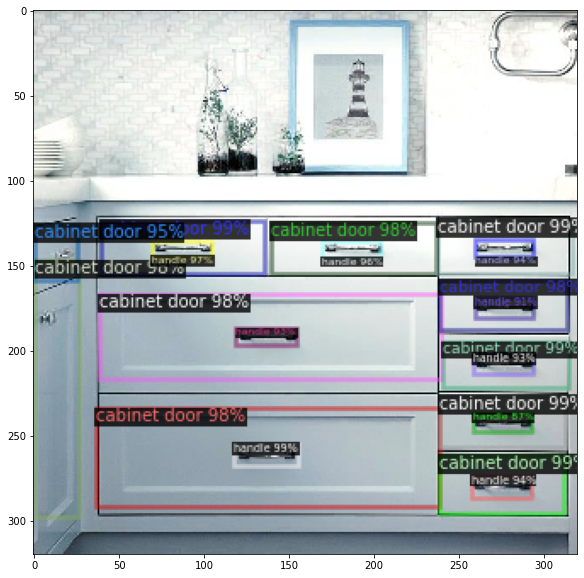

In [130]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts_test = DatasetCatalog.get("DoorDetectVer1_test")
for d in random.sample(dataset_dicts_test, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata= DoorDetectVer1_metadata, 
                   scale=0.5, 
                     # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(10,10))
    imgplot = plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
    

In [76]:
print(d["file_name"])

/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test/2e193eef6f6a4561.jpg


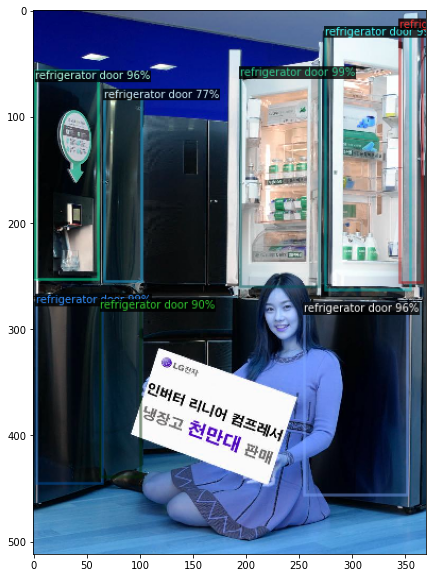

In [87]:
im = cv2.imread("/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test/2e193eef6f6a4561.jpg")
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
                   metadata= DoorDetectVer1_metadata, 
                   scale=0.5, 
                     # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(10,10))
imgplot = plt.imshow(out.get_image()[:, :, ::-1])
plt.show()
    

In [72]:
print(outputs)

{'instances': Instances(num_instances=7, image_height=1024, image_width=741, fields=[pred_boxes: Boxes(tensor([[394.9340, 124.5118, 527.7642, 503.8160],
        [557.7471,  85.5185, 702.6943, 517.3963],
        [537.1876, 555.4827, 711.8939, 930.7804],
        [  5.5739, 124.8344, 137.7008, 523.4044],
        [  5.8584, 557.0474, 124.7381, 909.9106],
        [557.5264,  54.0211, 723.0806, 876.9297],
        [ 10.9784, 210.5337, 135.5299, 913.4744]], device='cuda:0')), scores: tensor([0.9621, 0.9576, 0.9269, 0.8634, 0.7846, 0.7785, 0.7237],
       device='cuda:0'), pred_classes: tensor([3, 3, 3, 3, 3, 3, 3], device='cuda:0')])}


In [88]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("DoorDetectVer1_test", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "DoorDetectVer1_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[03/12 18:41:16 d2.data.datasets.coco]: Loaded 120 images in COCO format from /home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test.json
[03/12 18:41:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/12 18:41:16 d2.data.common]: Serializing 120 elements to byte tensors and concatenating them all ...
[03/12 18:41:16 d2.data.common]: Serialized dataset takes 0.12 MiB
[03/12 18:41:16 d2.evaluation.evaluator]: Start inference on 120 images
[03/12 18:41:17 d2.evaluation.evaluator]: Inference done 11/120. 0.0548 s / img. ETA=0:00:06
[03/12 18:41:22 d2.evaluation.evaluator]: Inference done 89/120. 0.0535 s / img. ETA=0:00:01
[03/12 18:41:24 d2.evaluation.evaluator]: Total inference time: 0:00:07.521673 (0.065406 s / img per device, on 1 devices)
[03/12 18:41:24 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:06 (0.053941 s / img per device, on 1 devic

TypeError: list indices must be integers or slices, not str

# MaskR-CNN

In [131]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("DoorDetectVer1_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") 
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  #number of classes

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/12 18:55:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[03/12 18:55:07 d2.data.datasets.coco]: Loaded 972 images in COCO format from /home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/train.json
[03/12 18:55:07 d2.data.build]: Removed 0 images with no usable annotations. 972 images left.
[03/12 18:55:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/12 18:55:08 d2.data.build]: Using training sampler TrainingSampler
[03/12 18:55:08 d2.data.common]: Serializing 972 elements to byte tensors and concatenating them all ...
[03/12 18:55:08 d2.data.common]: Serialized dataset takes 1.06 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

[03/12 18:55:08 d2.engine.train_loop]: Starting training from iteration 0
[03/12 18:55:12 d2.utils.events]:  eta: 0:18:42  iter: 19  total_loss: 3.472  loss_cls: 1.657  loss_box_reg: 0.3461  loss_mask: 0.6949  loss_rpn_cls: 0.5438  loss_rpn_loc: 0.1  time: 0.2255  data_time: 0.0072  lr: 4.9953e-06  max_mem: 3322M
[03/12 18:55:17 d2.utils.events]:  eta: 0:18:20  iter: 39  total_loss: 2.924  loss_cls: 1.571  loss_box_reg: 0.3791  loss_mask: 0.6883  loss_rpn_cls: 0.2497  loss_rpn_loc: 0.05295  time: 0.2274  data_time: 0.0066  lr: 9.9902e-06  max_mem: 3322M
[03/12 18:55:22 d2.utils.events]:  eta: 0:18:42  iter: 59  total_loss: 3.089  loss_cls: 1.347  loss_box_reg: 0.4522  loss_mask: 0.6748  loss_rpn_cls: 0.3965  loss_rpn_loc: 0.1067  time: 0.2306  data_time: 0.0024  lr: 1.4985e-05  max_mem: 3322M
[03/12 18:55:26 d2.utils.events]:  eta: 0:18:11  iter: 79  total_loss: 2.568  loss_cls: 1.131  loss_box_reg: 0.416  loss_mask: 0.6601  loss_rpn_cls: 0.3877  loss_rpn_loc: 0.08109  time: 0.2284  da

[03/12 18:57:43 d2.utils.events]:  eta: 0:16:27  iter: 659  total_loss: 1.575  loss_cls: 0.4036  loss_box_reg: 0.6565  loss_mask: 0.3418  loss_rpn_cls: 0.07544  loss_rpn_loc: 0.09779  time: 0.2350  data_time: 0.0078  lr: 0.00016484  max_mem: 3322M
[03/12 18:57:48 d2.utils.events]:  eta: 0:16:22  iter: 679  total_loss: 1.581  loss_cls: 0.4027  loss_box_reg: 0.5714  loss_mask: 0.3433  loss_rpn_cls: 0.07667  loss_rpn_loc: 0.06118  time: 0.2349  data_time: 0.0085  lr: 0.00016983  max_mem: 3322M
[03/12 18:57:53 d2.utils.events]:  eta: 0:16:18  iter: 699  total_loss: 1.452  loss_cls: 0.3932  loss_box_reg: 0.5431  loss_mask: 0.3068  loss_rpn_cls: 0.05108  loss_rpn_loc: 0.07807  time: 0.2353  data_time: 0.0025  lr: 0.00017483  max_mem: 3322M
[03/12 18:57:57 d2.utils.events]:  eta: 0:16:13  iter: 719  total_loss: 1.465  loss_cls: 0.3749  loss_box_reg: 0.5964  loss_mask: 0.3011  loss_rpn_cls: 0.05243  loss_rpn_loc: 0.1264  time: 0.2351  data_time: 0.0036  lr: 0.00017982  max_mem: 3322M
[03/12 18

[03/12 19:00:17 d2.utils.events]:  eta: 0:13:57  iter: 1319  total_loss: 1.194  loss_cls: 0.2794  loss_box_reg: 0.535  loss_mask: 0.2689  loss_rpn_cls: 0.04712  loss_rpn_loc: 0.06825  time: 0.2342  data_time: 0.0026  lr: 0.00025  max_mem: 3322M
[03/12 19:00:22 d2.utils.events]:  eta: 0:13:52  iter: 1339  total_loss: 1.293  loss_cls: 0.3395  loss_box_reg: 0.4944  loss_mask: 0.2681  loss_rpn_cls: 0.06011  loss_rpn_loc: 0.1076  time: 0.2341  data_time: 0.0026  lr: 0.00025  max_mem: 3322M
[03/12 19:00:27 d2.utils.events]:  eta: 0:13:46  iter: 1359  total_loss: 1.341  loss_cls: 0.3485  loss_box_reg: 0.5308  loss_mask: 0.2752  loss_rpn_cls: 0.05723  loss_rpn_loc: 0.126  time: 0.2341  data_time: 0.0029  lr: 0.00025  max_mem: 3322M
[03/12 19:00:31 d2.utils.events]:  eta: 0:13:42  iter: 1379  total_loss: 1.278  loss_cls: 0.3355  loss_box_reg: 0.5076  loss_mask: 0.2798  loss_rpn_cls: 0.05711  loss_rpn_loc: 0.1118  time: 0.2340  data_time: 0.0027  lr: 0.00025  max_mem: 3322M
[03/12 19:00:36 d2.ut

[03/12 19:02:51 d2.utils.events]:  eta: 0:11:21  iter: 1979  total_loss: 1.127  loss_cls: 0.2847  loss_box_reg: 0.4533  loss_mask: 0.2706  loss_rpn_cls: 0.03996  loss_rpn_loc: 0.05248  time: 0.2337  data_time: 0.0026  lr: 0.00025  max_mem: 3322M
[03/12 19:02:56 d2.utils.events]:  eta: 0:11:17  iter: 1999  total_loss: 1.128  loss_cls: 0.2608  loss_box_reg: 0.4157  loss_mask: 0.2734  loss_rpn_cls: 0.03604  loss_rpn_loc: 0.06183  time: 0.2336  data_time: 0.0088  lr: 0.00025  max_mem: 3322M
[03/12 19:03:00 d2.utils.events]:  eta: 0:11:12  iter: 2019  total_loss: 1.115  loss_cls: 0.2504  loss_box_reg: 0.4359  loss_mask: 0.2544  loss_rpn_cls: 0.04429  loss_rpn_loc: 0.06972  time: 0.2337  data_time: 0.0088  lr: 0.00025  max_mem: 3322M
[03/12 19:03:05 d2.utils.events]:  eta: 0:11:09  iter: 2039  total_loss: 1.049  loss_cls: 0.269  loss_box_reg: 0.429  loss_mask: 0.2462  loss_rpn_cls: 0.03892  loss_rpn_loc: 0.06689  time: 0.2338  data_time: 0.0041  lr: 0.00025  max_mem: 3322M
[03/12 19:03:10 d2

[03/12 19:05:25 d2.utils.events]:  eta: 0:08:52  iter: 2639  total_loss: 1.126  loss_cls: 0.2841  loss_box_reg: 0.4246  loss_mask: 0.2666  loss_rpn_cls: 0.02439  loss_rpn_loc: 0.09075  time: 0.2336  data_time: 0.0026  lr: 0.00025  max_mem: 3322M
[03/12 19:05:30 d2.utils.events]:  eta: 0:08:48  iter: 2659  total_loss: 1.089  loss_cls: 0.2692  loss_box_reg: 0.4885  loss_mask: 0.2619  loss_rpn_cls: 0.03176  loss_rpn_loc: 0.05638  time: 0.2336  data_time: 0.0028  lr: 0.00025  max_mem: 3322M
[03/12 19:05:35 d2.utils.events]:  eta: 0:08:43  iter: 2679  total_loss: 1.034  loss_cls: 0.2198  loss_box_reg: 0.4306  loss_mask: 0.2543  loss_rpn_cls: 0.0221  loss_rpn_loc: 0.05075  time: 0.2336  data_time: 0.0026  lr: 0.00025  max_mem: 3322M
[03/12 19:05:39 d2.utils.events]:  eta: 0:08:39  iter: 2699  total_loss: 1.133  loss_cls: 0.2965  loss_box_reg: 0.447  loss_mask: 0.2575  loss_rpn_cls: 0.03491  loss_rpn_loc: 0.1017  time: 0.2336  data_time: 0.0029  lr: 0.00025  max_mem: 3322M
[03/12 19:05:44 d2.

[03/12 19:08:00 d2.utils.events]:  eta: 0:06:24  iter: 3299  total_loss: 1.096  loss_cls: 0.2248  loss_box_reg: 0.43  loss_mask: 0.2487  loss_rpn_cls: 0.02  loss_rpn_loc: 0.05712  time: 0.2337  data_time: 0.0027  lr: 0.00025  max_mem: 3322M
[03/12 19:08:05 d2.utils.events]:  eta: 0:06:20  iter: 3319  total_loss: 1.147  loss_cls: 0.2537  loss_box_reg: 0.4158  loss_mask: 0.2601  loss_rpn_cls: 0.03714  loss_rpn_loc: 0.08358  time: 0.2337  data_time: 0.0026  lr: 0.00025  max_mem: 3322M
[03/12 19:08:09 d2.utils.events]:  eta: 0:06:15  iter: 3339  total_loss: 0.98  loss_cls: 0.2246  loss_box_reg: 0.3816  loss_mask: 0.2536  loss_rpn_cls: 0.0262  loss_rpn_loc: 0.02852  time: 0.2337  data_time: 0.0026  lr: 0.00025  max_mem: 3322M
[03/12 19:08:14 d2.utils.events]:  eta: 0:06:10  iter: 3359  total_loss: 1.274  loss_cls: 0.2638  loss_box_reg: 0.5525  loss_mask: 0.2673  loss_rpn_cls: 0.02659  loss_rpn_loc: 0.08703  time: 0.2338  data_time: 0.0035  lr: 0.00025  max_mem: 3322M
[03/12 19:08:19 d2.util

[03/12 19:10:36 d2.utils.events]:  eta: 0:03:56  iter: 3959  total_loss: 0.8165  loss_cls: 0.1567  loss_box_reg: 0.3929  loss_mask: 0.2214  loss_rpn_cls: 0.01504  loss_rpn_loc: 0.05103  time: 0.2340  data_time: 0.0036  lr: 0.00025  max_mem: 3322M
[03/12 19:10:40 d2.utils.events]:  eta: 0:03:51  iter: 3979  total_loss: 0.9904  loss_cls: 0.2105  loss_box_reg: 0.4358  loss_mask: 0.2334  loss_rpn_cls: 0.02159  loss_rpn_loc: 0.06822  time: 0.2340  data_time: 0.0075  lr: 0.00025  max_mem: 3322M
[03/12 19:10:45 d2.utils.events]:  eta: 0:03:47  iter: 3999  total_loss: 0.9518  loss_cls: 0.1983  loss_box_reg: 0.4119  loss_mask: 0.2508  loss_rpn_cls: 0.02373  loss_rpn_loc: 0.07148  time: 0.2340  data_time: 0.0026  lr: 0.00025  max_mem: 3322M
[03/12 19:10:50 d2.utils.events]:  eta: 0:03:42  iter: 4019  total_loss: 0.9385  loss_cls: 0.2128  loss_box_reg: 0.4397  loss_mask: 0.2477  loss_rpn_cls: 0.01839  loss_rpn_loc: 0.05485  time: 0.2340  data_time: 0.0065  lr: 0.00025  max_mem: 3322M
[03/12 19:10

[03/12 19:13:11 d2.utils.events]:  eta: 0:01:26  iter: 4619  total_loss: 0.9641  loss_cls: 0.1997  loss_box_reg: 0.3905  loss_mask: 0.2494  loss_rpn_cls: 0.02421  loss_rpn_loc: 0.06106  time: 0.2341  data_time: 0.0027  lr: 0.00025  max_mem: 3322M
[03/12 19:13:15 d2.utils.events]:  eta: 0:01:21  iter: 4639  total_loss: 1  loss_cls: 0.2071  loss_box_reg: 0.4282  loss_mask: 0.2399  loss_rpn_cls: 0.02397  loss_rpn_loc: 0.05394  time: 0.2341  data_time: 0.0031  lr: 0.00025  max_mem: 3322M
[03/12 19:13:20 d2.utils.events]:  eta: 0:01:17  iter: 4659  total_loss: 0.9224  loss_cls: 0.1806  loss_box_reg: 0.396  loss_mask: 0.2447  loss_rpn_cls: 0.01886  loss_rpn_loc: 0.07362  time: 0.2341  data_time: 0.0028  lr: 0.00025  max_mem: 3322M
[03/12 19:13:25 d2.utils.events]:  eta: 0:01:12  iter: 4679  total_loss: 1.02  loss_cls: 0.2063  loss_box_reg: 0.447  loss_mask: 0.2457  loss_rpn_cls: 0.01641  loss_rpn_loc: 0.06334  time: 0.2341  data_time: 0.0041  lr: 0.00025  max_mem: 3322M
[03/12 19:13:29 d2.ut

In [137]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7497), started 3:21:21 ago. (Use '!kill 7497' to kill it.)

In [133]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[03/12 19:21:29 d2.data.datasets.coco]: Loaded 120 images in COCO format from /home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test.json


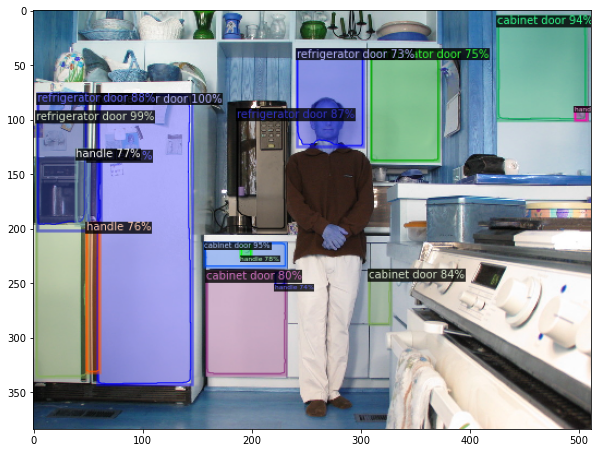

In [134]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts_test = DatasetCatalog.get("DoorDetectVer1_test")
for d in random.sample(dataset_dicts_test, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata= DoorDetectVer1_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW# remove the colors of unsegmented pixels. This option is only available for segmentation models
    
                  )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(10,10))
    imgplot = plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

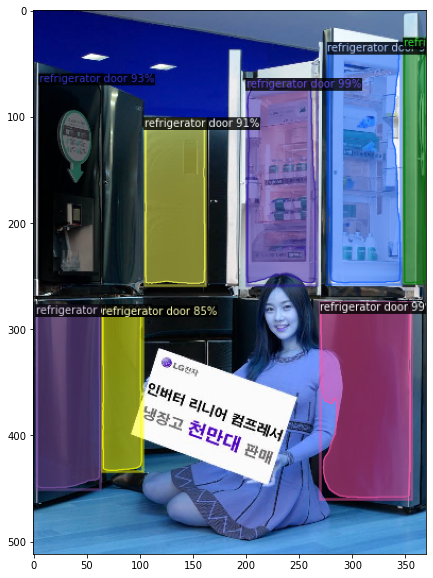

In [135]:
im = cv2.imread("/home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test/2e193eef6f6a4561.jpg")
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
                   metadata= DoorDetectVer1_metadata, 
                   scale=0.5, 
                     # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(10,10))
imgplot = plt.imshow(out.get_image()[:, :, ::-1])
plt.show()

In [136]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("DoorDetectVer1_test", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "DoorDetectVer1_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[03/12 19:22:35 d2.data.datasets.coco]: Loaded 120 images in COCO format from /home/jyoti/Desktop/csc8800/datasets/DoorDetectDataset/test.json
[03/12 19:22:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/12 19:22:35 d2.data.common]: Serializing 120 elements to byte tensors and concatenating them all ...
[03/12 19:22:35 d2.data.common]: Serialized dataset takes 0.12 MiB
[03/12 19:22:35 d2.evaluation.evaluator]: Start inference on 120 images
[03/12 19:22:36 d2.evaluation.evaluator]: Inference done 11/120. 0.0649 s / img. ETA=0:00:10
[03/12 19:22:41 d2.evaluation.evaluator]: Inference done 50/120. 0.0634 s / img. ETA=0:00:08
[03/12 19:22:46 d2.evaluation.evaluator]: Inference done 94/120. 0.0620 s / img. ETA=0:00:03
[03/12 19:22:49 d2.evaluation.evaluator]: Total inference time: 0:00:13.673551 (0.118900 s / img per device, on 1 devices)
[03/12 19:22:49 d2.evaluation.ev